In [5]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import yfinance as yf 
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date

In [6]:
# update code to use yfinance with padas_datareader
# code update for 2023: https://github.com/ranaroussi/yfinance
yf.pdr_override() # <== that's all it takes

In [7]:
stock_list = ['AMD','XSD','SMH','SOXX','IVV']
start_date = '2017-01-01'
end_date = date.today()

In [8]:
df = data.get_data_yahoo(stock_list, data_source = 'yahoo', start=start_date, end=end_date)
df.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                                                Close  \
                 AMD         IVV        SMH        SOXX        XSD    AMD   
Date                                                                        
2017-01-03     11.43  203.194946  66.796890  114.745071  54.670773  11.43   
2017-01-04     11.43  204.423523  67.010979  115.062981  55.019238  11.43   
2017-01-05     11.24  204.235229  66.620033  114.081223  54.322292  11.24   
2017-01-06     11.32  205.042297  66.964447  114.988182  54.544933  11.32   
2017-01-09     11.49  204.378677  67.737038  116.203697  55.145065  11.49   

                                                          ...   Open  \
                   IVV        SMH        SOXX        XSD  ...    AMD   
Date                                                      ...          
2017-01-03  226.580002  71.760002  122.720001  56.480000  ...  11.42   
2017-01-04  227.949997  71.989998  123.059998  56.840000  ...  11.45   
2017-01-05  227.740005  71.570000  122.010002  56.119999  ...  11.43   
2017-01-06  228.639999  71.940002  122.980003  56.349998  ...  11.29   
2017-01-09  227.899994  72.769997  124.279999  56.970001  ...  11.37   

                                                            Volume           \
                   IVV        SMH        SOXX        XSD       AMD      IVV   
Date                                                                          
2017-01-03  226.399994  72.839996  123.139999  56.570000  55182000  6396600   
2017-01-04  226.960007  72.080002  123.330002  56.669998  40781200  4099000   
2017-01-05  227.630005  72.160004  123.129997  56.720001  38855200  2970100   
2017-01-06  227.910004  71.669998  122.309998  56.200001  34453500  3110100   
2017-01-09  228.270004  72.040001  123.410004  56.400002  37304800  2360600   

                                     
                SMH    SOXX     XSD  
Date                                 
2017-01-03  2870700  884700  286700  
2017-01-04  1935200  451400   94000  
2017-01-05  1508300  314000   34300  
2017-01-06  2594000  291700   39300  
2017-01-09  2354200  294600   49400  

[5 rows x 30 columns]

In [9]:
# Closing price
df = df['Adj Close']
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2017-01-03 to 2023-03-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1551 non-null   float64
 1   IVV     1551 non-null   float64
 2   SMH     1551 non-null   float64
 3   SOXX    1551 non-null   float64
 4   XSD     1551 non-null   float64
dtypes: float64(5)
memory usage: 72.7 KB


### Pretty frontier

https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5

Note: this code is optimized for stock with 252 trading day, so chaging the number of trading day significantly affect the optimize function

It seems like there is an onging debate whether we should use normal return or log return. Log return make more senses to me so I will use log return, but I will also test normal return

In [10]:
log_ret = np.log(df/df.shift(1))
log_ret.head()

,AMD,IVV,SMH,SOXX,XSD
Date,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.000000,0.006028,0.003200,0.002767,0.006354
2017-01-05,-0.016763,-0.000922,-0.005851,-0.008569,-0.012748
2017-01-06,0.007092,0.003944,0.005157,0.007919,0.004090
2017-01-09,0.014906,-0.003242,0.011471,0.010515,0.010942


In [11]:
np.random.seed(123)
num_ports = 5000
all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
rf = 0.04 #risk-free rate of treasury bond
for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(df.columns))) #number of random weight equal number of tickers
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252)) #crypto trading is 365 days/year, stock trading 252 days/year
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = (ret_arr[x]-rf)/vol_arr[x]

In [12]:
print('Max Sharpe ratio in the array: {}'.format(sharpe_arr.max()))

#numpy.argmax Returns the indices of the maximum values along an axis.

print('Index of max Sharpe ratio in the array: {}'.format(sharpe_arr.argmax())) 

Max Sharpe ratio in the array: 0.5413251954377952
Index of max Sharpe ratio in the array: 4533


The best portfolio is on index 9520. Let’s check the allocation weights in that index number and save the return and volatility figures to use it in the chart later.

In [13]:
print('Max Sharpe ratio allocation: {}'.format(all_weights[sharpe_arr.argmax(),:]))

Max Sharpe ratio allocation: [0.26926515 0.01333819 0.47708161 0.19530102 0.04501403]


In [14]:
#print expected return of max sharpe ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
print('Return of portfolio with highest Sharpe ratio: {}'.format(max_sr_ret))
# Print expected volatility of portfolio with highest Sharpe ratio
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print('Volatility of portfolio with highest Sharpe ratio: {}'.format(max_sr_vol))

Return of portfolio with highest Sharpe ratio: 0.23679838894234503
Volatility of portfolio with highest Sharpe ratio: 0.36354928719544427


In [15]:
#print expected return of minimum volatility
min_vol_ret = ret_arr[vol_arr.argmin()]
print('Return of portfolio with : {}'.format(min_vol_ret))
# Print miminum volatility
min_vol = vol_arr.min()
print('Lowest volatility: {}'.format(min_vol))

Return of portfolio with : 0.13400478003690364
Lowest volatility: 0.22448185881070523


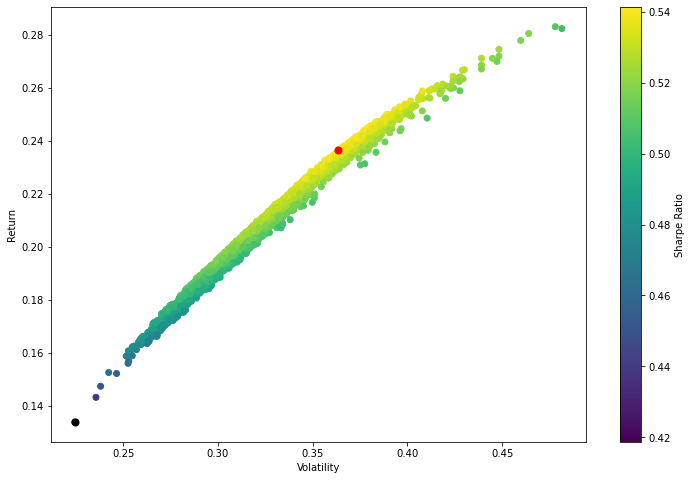

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.scatter(min_vol, min_vol_ret,c='black', s=50) # black dot
plt.show()

To solve the Sharpe Ratio maximization model, we make use of the minimize library function from scipy.optimize package of Python. However, since the original objective function insists on maximization as opposed to minimization demanded by the minimize solver, the principal of duality borrowed from **Optimization Theory** is employed to undertake the transformation. According to the principle:
max(f(x)) = -min(-f(x))

In [17]:
def get_ret_vol_sr(weights):
    #return an array with: return, volatility and sharpe ratio from any given set of weights
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252 #if stock, multiple by 252 trading days
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = (ret-rf)/vol #add risk-free rate
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    #return the negative Sharpe ratio from some weights, which we will use to minimize later
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [20]:
#begin with equal weight allocation, for 5 tokens each will have weight of 0.2
cons = ({'type':'eq','fun': check_sum})

#the bounds will be a tuple (0,1) for each stock, since the weight can range from 0 to 1.
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
init_guess = np.repeat(1/len(df.columns),len(df.columns))

In [21]:
from scipy.optimize import minimize 
# to minimize negative Sharpe ratio, we use SLSQP (Sequential Least Squares Programming) which is the most common method for generic minimization problems
opt_returns = minimize(neg_sharpe, init_guess, method = 'SLSQP',bounds = bounds, constraints = cons)
print(opt_returns)

     fun: -0.5442783447863574
     jac: array([-0.10768662, -0.06554434, -0.10885713, -0.09939548, -0.1039535 ])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([2.90770180e-01, 0.00000000e+00, 7.09229820e-01, 4.65664833e-17,
       6.90094683e-17])


In [19]:
get_ret_vol_sr(opt_returns.x) # to get  return, volatility, and sharpe ratio of optimized return

array([0.25439178, 0.32574673, 0.65815483])

Using scipy optimizer we get bigger sharpe ratio? previously sharpe ratio = 0.86. Now it is 0.89
Also sharpe ratio <1 is considered less than good

To finish the plotting of the frontier, we have define one last function that will help us minimize the volatility. It will return the volatility (index 1) of the given weights.

In [22]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [23]:
frontier_y = np.linspace(0.15,0.3,200) #Return evenly spaced numbers over a specified interval

#The for loop is basically going through every possible value in our previously defined frontier_y and obtaining the minimum result (which is the key ‘fun’) of volatility (our x axis in the chart).
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

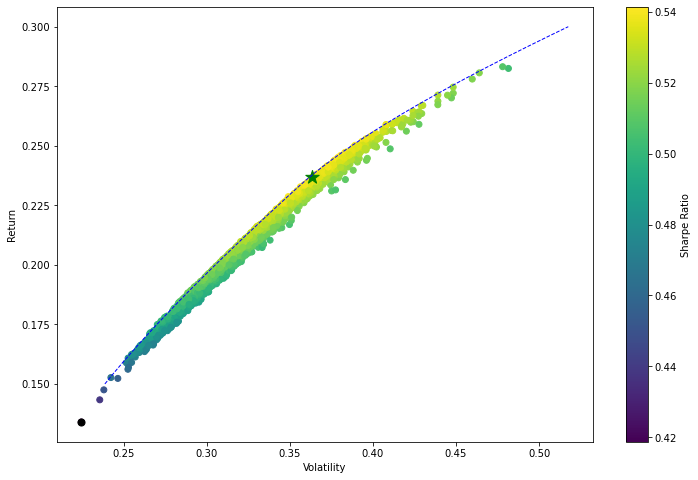

In [24]:
#plot the actual efficient frontier by passing the variables frontier_x and frontier_y
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,color='g', marker='*', s=200) # red dot
plt.scatter(min_vol, min_vol_ret,c='black', s=50) # black dot
plt.plot(frontier_x,frontier_y, 'b--', linewidth=1)
#plt.savefig('cover.png')
plt.show()

**Using normal return**

In [25]:
df.head()

,AMD,IVV,SMH,SOXX,XSD
Date,,,,,
2017-01-03,11.43,203.194946,66.796890,114.745071,54.670773
2017-01-04,11.43,204.423523,67.010979,115.062981,55.019238
2017-01-05,11.24,204.235229,66.620033,114.081223,54.322292
2017-01-06,11.32,205.042297,66.964447,114.988182,54.544933
2017-01-09,11.49,204.378677,67.737038,116.203697,55.145065


In [26]:
nor_ret=df.pct_change()
nor_ret.head()

,AMD,IVV,SMH,SOXX,XSD
Date,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.000000,0.006046,0.003205,0.002771,0.006374
2017-01-05,-0.016623,-0.000921,-0.005834,-0.008532,-0.012667
2017-01-06,0.007117,0.003952,0.005170,0.007950,0.004099
2017-01-09,0.015018,-0.003237,0.011537,0.010571,0.011003


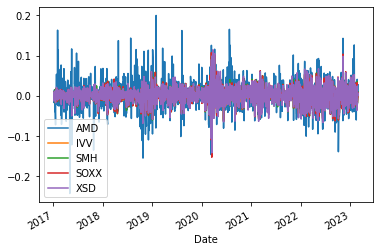

In [27]:
nor_ret.plot()
plt.show()

In [28]:
np.random.seed(123)
num_ports = 5000
nor_all_weights = np.zeros((num_ports, len(df.columns)))
nor_ret_arr = np.zeros(num_ports)
nor_vol_arr = np.zeros(num_ports)
nor_sharpe_arr = np.zeros(num_ports)
rf = 0.04 #risk-free rate of treasury bond
for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(df.columns))) #number of random weight equal number of tickers
    weights = weights/np.sum(weights)
    
    # Save weights
    nor_all_weights[x,:] = weights
    
    # Expected return
    nor_ret_arr[x] = np.sum((nor_ret.mean() * weights * 252)) #crypto trading is 365 days/year, stock trading 252 days/year
    
    # Expected volatility
    nor_vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(nor_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    nor_sharpe_arr[x] = (nor_ret_arr[x]-rf)/nor_vol_arr[x]

In [29]:
print('Max Sharpe ratio in the array: {}'.format(nor_sharpe_arr.max()))

#numpy.argmax Returns the indices of the maximum values along an axis.

print('Index of max Sharpe ratio in the array: {}'.format(nor_sharpe_arr.argmax())) 

Max Sharpe ratio in the array: 0.7947344097841978
Index of max Sharpe ratio in the array: 2179


In [30]:
#print expected return of max sharpe ratio
nor_max_sr_ret = nor_ret_arr[nor_sharpe_arr.argmax()]
print('Return of portfolio with : {}'.format(nor_max_sr_ret))
# Print volatility of max sharpe ratio
nor_max_sr_vol = nor_vol_arr[nor_sharpe_arr.argmax()]
print('Lowest volatility: {}'.format(nor_max_sr_vol))

Return of portfolio with : 0.3886871098622452
Lowest volatility: 0.4387467128256441


In [31]:
#print expected return of minimum volatility
nor_min_vol_ret = nor_ret_arr[nor_vol_arr.argmin()]
print('Return of portfolio with : {}'.format(nor_min_vol_ret))
# Print miminum volatility
nor_min_vol = nor_vol_arr.min()
print('Lowest volatility: {}'.format(nor_min_vol))

Return of portfolio with : 0.16316051359697933
Lowest volatility: 0.22361766858200138


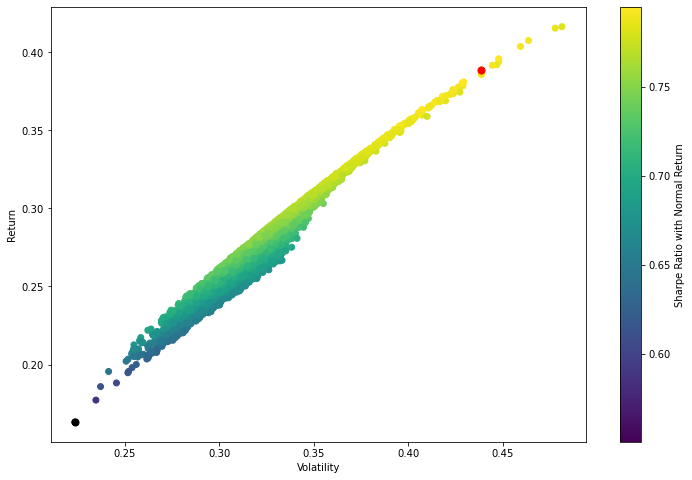

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(nor_vol_arr, nor_ret_arr, c=nor_sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio with Normal Return')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(nor_max_sr_vol, nor_max_sr_ret,c='red', s=50) # red dot
plt.scatter(nor_min_vol, nor_min_vol_ret,c='black', s=50) # black dot
plt.show()

#### table that summary weights of portfolio with highest sharpe ratio

In [33]:
port_weights = pd.DataFrame(zip(df.columns,all_weights[sharpe_arr.argmax()],opt_returns.x, nor_all_weights[nor_sharpe_arr.argmax()]), columns = ['fund','log_ret','log_ret_opt','nor_ret'])

In [34]:
port_weights['log_ret_opt'] = port_weights['log_ret_opt'].apply(lambda x: '%.7f' % x)
port_weights

,fund,log_ret,log_ret_opt,nor_ret
0,AMD,0.269265,0.2907702,0.579253
1,IVV,0.013338,0.0000000,0.005078
2,SMH,0.477082,0.7092298,0.224897
3,SOXX,0.195301,0.0000000,0.098718
4,XSD,0.045014,0.0000000,0.092055


In [ ]:
float('3.182039e-01')